# Basic experiment

# Make toy data

 Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

 Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [ ]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [ ]:
rho = 0.8
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

In [ ]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [4]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [5]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint, marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - torch.mean(et))/(ma_et.mean().detach())
    # use biased estimator
    # loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [6]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1), data[marginal_index][:,1].reshape(-1,1)], axis=1)
    return batch

In [ ]:
joint_data = sample_batch(y, batch_size=100, sample_mode='joint')
sns.scatterplot(x=joint_data[:,0], y=joint_data[:,1], color='red')
marginal_data = sample_batch(y, batch_size=100, sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0], y=marginal_data[:,1])

In [7]:
def train(data, mine_net, mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data, batch_size), sample_batch(data, batch_size, sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [8]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0, len(a)-window_size)]

In [ ]:
mine_net_indep = Mine().cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = train(x, mine_net_indep, mine_net_optim_indep)

In [ ]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)), result_indep_ma)

In [ ]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(y, mine_net_cor, mine_net_optim_cor)

In [ ]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)), result_cor_ma)

# Test with various correlations

In [ ]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

In [ ]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0], cov=[[1,rho],[rho,1]], size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(rho_data, mine_net, mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)), result_ma)

In [ ]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-2.,high=2.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(np.pi*x)
f4 = x**3
f5 = np.exp(x)
eps = np.random.normal(size=3000)

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

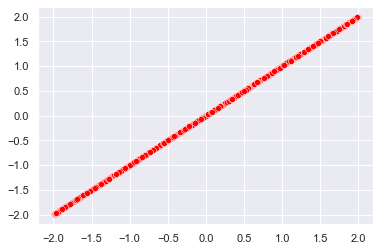

In [22]:
sns.scatterplot(x, f1, color='red')

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

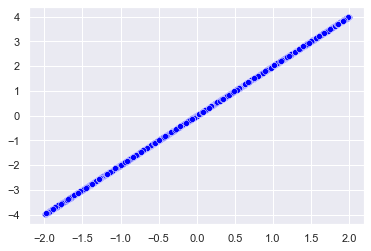

In [23]:
sns.scatterplot(x, f2, color='blue')

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

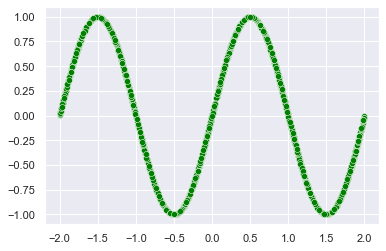

In [24]:
sns.scatterplot(x, f3, color='green')

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

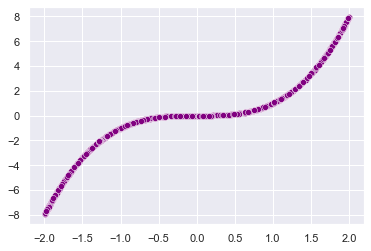

In [25]:
sns.scatterplot(x, f4,color='purple')

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

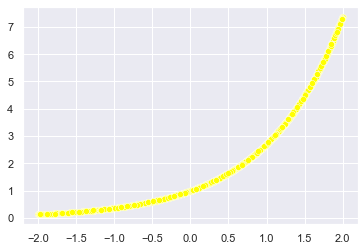

In [26]:
sns.scatterplot(x, f5, color='yellow')

In [27]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4, f5]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


5.173546
5.632267
4.9117403
4.1010876
5.1156483
0.0, 0: 6.044471
5.4586983
3.7480173
4.6089907
4.6583776
4.086601
0.0, 1: 7.1936975
0.083061606
0.028469704
0.023427512
0.11104372
0.1302773
0.0, 2: 0.16411674
0.9436995
1.2722735
1.6939001
1.8264682
2.335527
0.0, 3: 1.8813227
2.0723352
2.8573585
2.702746
3.363869
4.199291
0.0, 4: 3.2017767
2.448599
2.138141
2.0212667
2.7205079
2.826203
0.1, 0: 2.3402903
2.4158845
3.273019
3.0920274
2.1450343
2.7768958
0.1, 1: 3.1013322
0.11318633
0.026981702
0.1272615
0.25873452
0.28721136
0.1, 2: 0.41382802
1.2982372
1.5667719
1.7337735
1.5553768
1.7235558
0.1, 3: 1.9561368
1.5349373
1.9389988
1.7575043
2.9026878
2.6339848
0.1, 4: 2.2682757
1.6177704
1.5882646
1.6720055
1.7541811
1.8718865
0.2, 0: 1.6312543
2.3381746
2.4944131
2.1352403
2.7717478
1.8338255
0.2, 1: 2.2959898
0.093189016
0.060112875
0.15273212
0.27018416
0.49795085
0.2, 2: 0.3604702
0.91715354
1.1351012
1.1347901
1.4336778
1.42685
0.2, 3: 1.6930217
1.4109863
1.6793182
1.2956501
1.5018752


KeyboardInterrupt: 

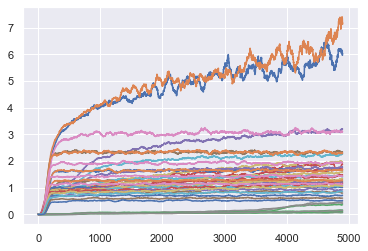

In [28]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
        result = train(data,mine_net,mine_net_optim,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ', ' + str(fi) +': ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [14]:
re_final_result = np.transpose(np.array([final_result[5*i: 5*i+5]  for i in range(10)]))
print(re_final_result)

[[5.291139   1.6564119  1.0627402  0.7607165  0.5426681  0.41156292
  0.32733423 0.24547014 0.20828678 0.16348498]
 [6.2936225  2.424303   1.669944   1.27738    1.04594    0.851512
  0.7461891  0.6190786  0.5613552  0.4656899 ]
 [1.3565087  1.1211165  0.88936406 0.69605285 0.56818277 0.46592772
  0.3837776  0.30527416 0.26272964 0.21601751]
 [1.2853531  1.01199    0.60874134 0.3734943  0.24842365 0.16980273
  0.13211517 0.10159521 0.07048332 0.05200498]
 [3.1188543  1.6947986  1.1074995  0.78546137 0.5860931  0.4705289
  0.3625486  0.2872294  0.24560131 0.21654741]]


In [ ]:
sns.heatmap(re_final_result, cmap="YlGnBu",linewidths=.5)